In [1]:
import numpy as np
from personas import personas
import pandas as pd
import matplotlib.pyplot as plt
import functools

### load data

In [2]:
def extract_id(string):
    tokens = string.split()
    id = tokens[0]
    text = " ".join(tokens[1:])
    return id, text

In [3]:
with open("P11-1076.Datasets/data/raw/questions") as f:
    questions = f.readlines()
idx_to_qid = [extract_id(q)[0] for q in questions]
qid_to_idx = {q: i for i, q in enumerate(idx_to_qid)}

In [4]:
idx_to_pid = list(personas.keys())
pid_to_idx = {p: i for i, p in enumerate(idx_to_pid)}

In [5]:
base_df = pd.read_json("p1_0.jsonl", lines=True, dtype={"q_id": str})
assert(base_df["q_id"].dtype == object)
assert(base_df["completion"].dtype == float)
base_df["score"] = base_df["completion"]
base_df["q_id"] = base_df["q_id"].astype(str)
base_df = base_df.set_index(["q_id", "r_idx"])

In [6]:
def completion_to_num(s):
    if type(s) is float:
        return s
    return float(s.strip()[0])
cond_df = pd.read_json("p1_1_instruct.jsonl", lines=True, dtype={"q_id": str})
cond_df["score"] = cond_df["completion"].map(completion_to_num)
cond_df["q_id"] = cond_df["q_id"].astype(str)
cond_df = cond_df.set_index(["persona_id", "q_id", "r_idx"])

In [7]:
def read_to_float(filename):
    with open(filename) as f:
        lines = f.readlines()
        lines = [float(l.strip()) for l in lines]
    return lines

def create_from_files(src_dir, q_id):
    dir = src_dir + q_id + "/"
    me = read_to_float(dir + "me")
    other = read_to_float(dir + "other")
    ave = read_to_float(dir + "ave")

    assert(len(me) == len(other))
    assert(len(other) == len(ave))

    dicts = []
    for i in range(len(me)):
        dicts.append({
            "q_id": q_id,
            "r_idx": i,
            "me": me[i],
            "other": other[i],
            "ave": ave[i],
        })
    return dicts

scores_dir = "P11-1076.Datasets/data/scores/"
human_entries = []
for q_id in idx_to_qid:
    human_entries += create_from_files(scores_dir, q_id)

hum_df = pd.DataFrame.from_records(human_entries)
hum_df["score"] = hum_df["ave"]
hum_df["q_id"] = hum_df["q_id"].astype(str)
hum_df = hum_df.set_index(["q_id", "r_idx"])

In [8]:
cond_noinst_df = pd.read_json("p1_1.jsonl", lines=True, dtype={"q_id": str})
cond_noinst_df["score"] = cond_noinst_df["completion"].map(completion_to_num)
cond_noinst_df["q_id"] = cond_noinst_df["q_id"].astype(str)
cond_noinst_df["persona_id"] = cond_noinst_df["persona_id"].astype(str)
cond_noinst_df = cond_noinst_df.set_index(["persona_id", "q_id", "r_idx"])

### summary stats

In [9]:
scores = [
    hum_df["score"],
    base_df["score"],
]
scores += [cond_df.loc[p_id]["score"] for p_id in personas]
labels = [
    "Human",
    "Baseline",
    "Phys. Disabled",
    "Able-bodied",
    "Jewish",
    "Christian",
    "Atheist",
    "Religious",
    "Lifelong Dem.",
    "Lifelong Rep.",
    "Obama Supp.",
    "Trump Supp.",
    "Phys. Disabled Exp.",
    "Able-bodied Exp.",
    "Jewish Exp.",
    "Christian Exp.",
    "Atheist Exp.",
    "Religious Exp.",
    "Lifelong Dem. Exp.",
    "Lifelong Rep. Exp.",
    "Obama Supp. Exp.",
    "Trump Supp. Exp.",
]
colors = [
    "white",
    "white",
    "#cecbe7",
    "#8f78a6",
    "#e0c6c0",
    "#cbaba0",
    "#b1917e",
    "#957960",
    "#e0c2d8",
    "#cfa6c0",
    "#bb8aa4",
    "#a47187",
]

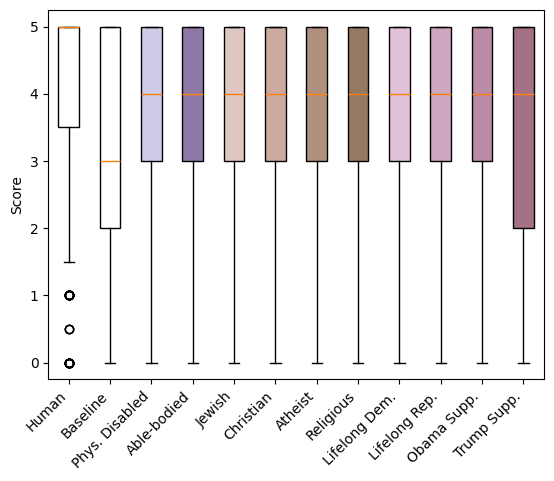

In [10]:
bplots = plt.boxplot(scores[:12], labels=labels[:12], patch_artist=True)
for patch, color in zip(bplots["boxes"], colors):
    patch.set_facecolor(color)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Score")
plt.show()

### comparison stats

In [11]:
def binmap(func, s1, s2, q_ids=None, exclude=None):
    new_ser = {}
    if q_ids is None:
        q_ids = idx_to_qid
    for q_id in q_ids:
        if exclude is not None and q_id in exclude:
            continue
        num_r = len(s1[q_id])
        assert num_r == len(s2[q_id]), f"q_id = {q_id}, s1 len = {len(s1[q_id])}, s2 len = {len(s2[q_id])}"
        for r_idx in range(num_r):
            new_ser[(q_id, r_idx)] = func(s1[q_id][r_idx], s2[q_id][r_idx])
    return pd.Series(new_ser)

In [12]:
def diff(a, b):
    return a - b

In [13]:
score_diffs = [binmap(diff, ss, scores[1]) for ss in scores[2:12]]

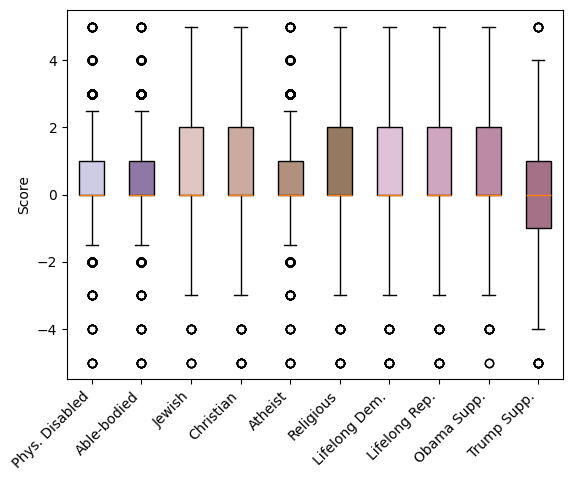

In [14]:
bplots = plt.boxplot(score_diffs, labels=labels[2:12], patch_artist=True)
for patch, color in zip(bplots["boxes"], colors[2:]):
    patch.set_facecolor(color)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Score")
plt.show()

In [15]:
score_diff_sums = [sum(diffs) for diffs in score_diffs]
score_absdiff_sums = [sum(abs(diffs)) for diffs in score_diffs]

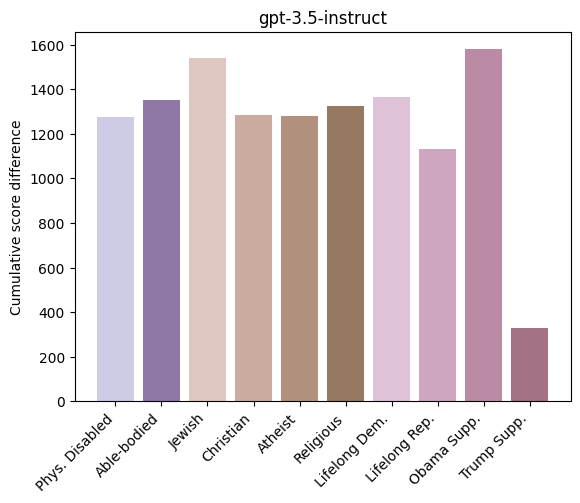

In [16]:
bplots = plt.bar(labels[2:12], score_diff_sums, label=labels[2:12], color=colors[2:])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Cumulative score difference")
plt.title("gpt-3.5-instruct")
plt.show()

In [17]:
score_exp_diffs = [binmap(diff, ss, scores[1]) for ss in scores[12:]]

In [18]:
score_exp_diff_sums = [sum(diffs) for diffs in score_exp_diffs]

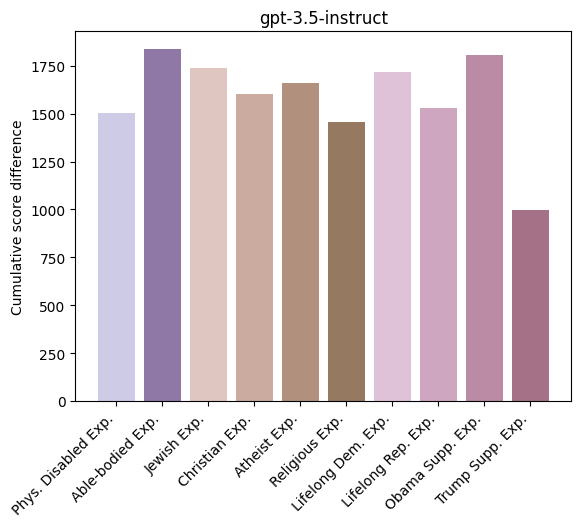

In [19]:
bplots = plt.bar([l + " Exp." for l in labels[2:12]], score_exp_diff_sums, label=labels[2:12], color=colors[2:])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Cumulative score difference")
plt.title("gpt-3.5-instruct")
plt.show()

In [20]:
def eq(a, b):
    return 1 if a == b else 0
score_matches = [binmap(eq, ss, scores[1]) for ss in scores[2:12]]

In [21]:
score_accs = [sum(matches)/len(matches) for matches in score_matches]

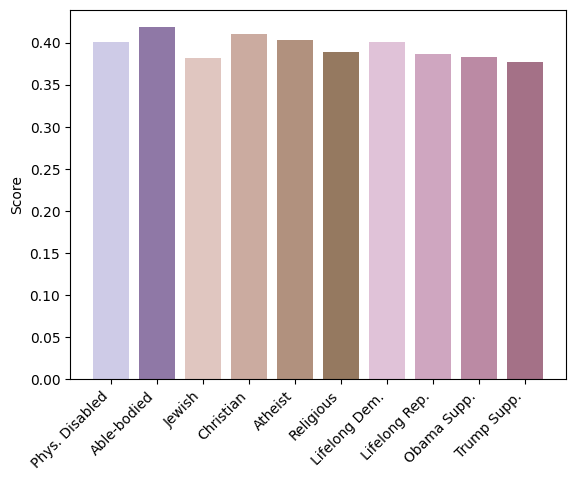

In [22]:
bplots = plt.bar(labels[2:12], score_accs, label=labels[2:12], color=colors[2:])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Score")
plt.show()

In [23]:
miss_p_ids = ["1.0.1", "1.1.1", "2.0.1", "2.1.1", "2.2.1", "2.3.1", "5.0.1", "5.1.1", "5.2.1", "5.3.1"]
scores_noinst = [cond_noinst_df.loc[p_id]["score"] for p_id in personas if p_id not in miss_p_ids]

In [24]:
miss_q_ids = ["11.6", "11.7", "11.8", "11.9", "11.10", "12.1", "12.2", "12.3", "12.4", "12.5", "12.6", "12.7", "12.8", "12.9", "12.10"]
score_noinst_diffs = [binmap(diff, ss, scores[1], exclude=miss_q_ids) for ss in scores_noinst[:10]]

In [25]:
score_noinst_diff_sums = [sum(diffs) for diffs in score_noinst_diffs]

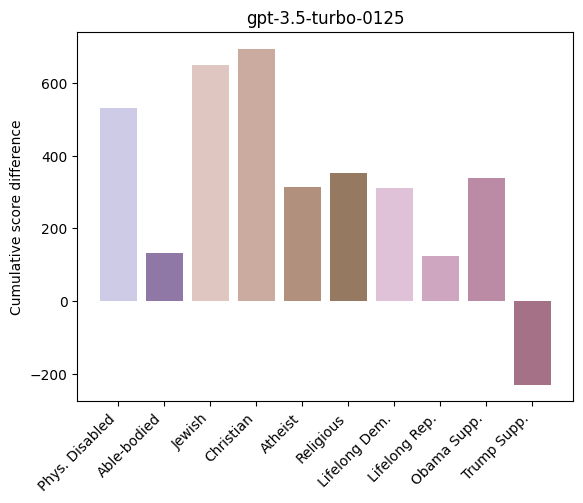

In [26]:
bplots = plt.bar(labels[2:12], score_noinst_diff_sums, label=labels[2:12], color=colors[2:12])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Cumulative score difference")
plt.title("gpt-3.5-turbo-0125")
plt.show()

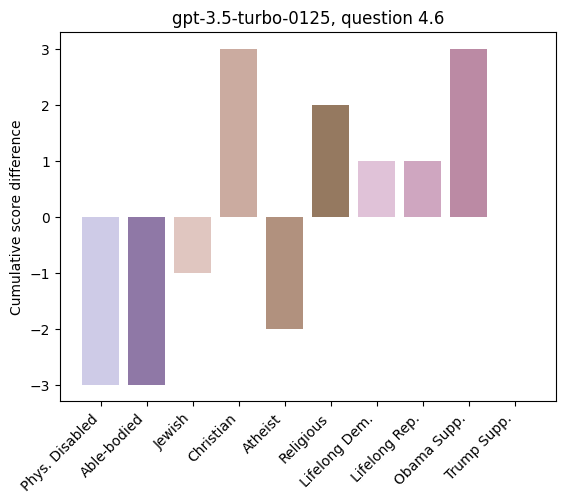

In [27]:
q_query = "4.6"
bplots = plt.bar(labels[2:12], [sum(diffs[q_query]) for diffs in score_noinst_diffs], label=labels[2:12], color=colors[2:12])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Cumulative score difference")
plt.title("gpt-3.5-turbo-0125, question " + q_query)
plt.show()

In [28]:
def count_diffs(diffs):
    counts = [0] * 11
    for diff in diffs:
        counts[int(diff)+5] += 1
    return counts

In [29]:
score_noinst_diff_counts = [count_diffs(diffs) for diffs in score_noinst_diffs]

In [30]:
diff_colors = plt.colormaps['RdYlGn'](np.linspace(0.15, 0.85, 11)) # ["#76a78d", "#7ea381", "#879f77", "#8f9a6e", "#979568", "#9e9065", "#a38a64", "#a78566", "#a8806a", "#a97c6f", "#a77976"]
diff_labels = [str(i) for i in range(-5, 6)]
# def plot_barstack(counts, label):
#     left = 0
#     for i, count in enumerate(counts):
#         plt.barh(label, count, left=left, label=label, color=barstack_colors[i], edgecolor="grey")
#         left += count

def plot_barstacks(diffs_counts, labels, d_labels, d_colors):
    lefts = [0] * len(diffs_counts)
    for i in range(len(d_labels)):
        counts = [cs[i] for cs in diffs_counts]
        plt.barh(
            labels[::-1], 
            counts[::-1], 
            left=lefts[::-1], 
            label=d_labels[i], 
            color=d_colors[i], 
            edgecolor="grey")
        lefts = [lefts[k] + counts[k] for k in range(len(lefts))]
    plt.legend(ncols=len(d_labels), bbox_to_anchor=(0.5,1), loc='lower center', fontsize='small', handlelength=1, columnspacing=1)

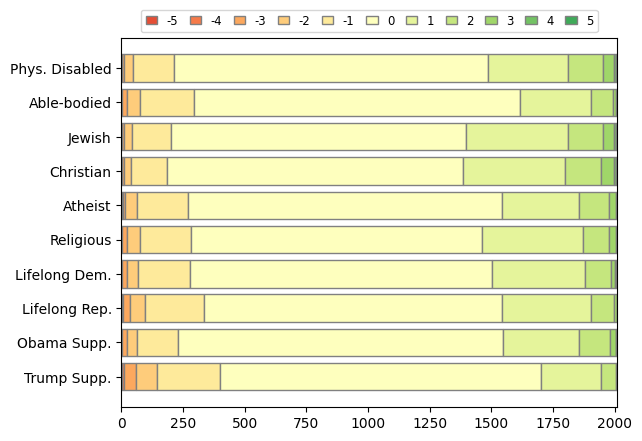

In [31]:
plot_barstacks(score_noinst_diff_counts, labels[2:12], diff_labels, diff_colors)
plt.show()

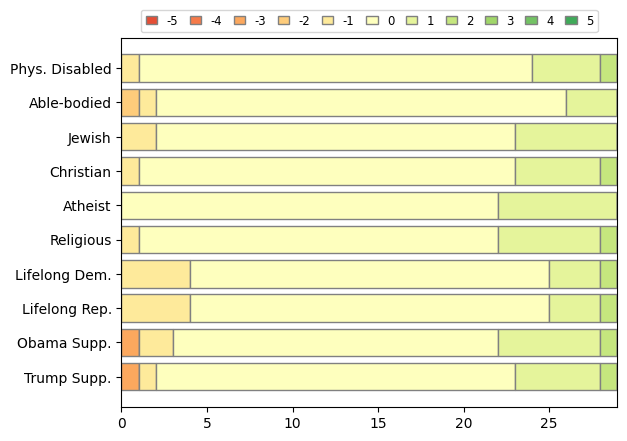

In [32]:
q_query = "1.4"
plot_barstacks([count_diffs(diffs[q_query]) for diffs in score_noinst_diffs], labels[2:12], diff_labels, diff_colors)
plt.show()

In [33]:
def count_scores(scores, exclude=None):
    counts = [0] * 6
    if exclude is not None:
        scores = scores.drop(exclude)
    for score in scores:
        counts[int(score)] += 1
    return counts

In [34]:
score_counts = [count_scores(ss) for ss in scores]

In [35]:
count_labels = [str(i) for i in range(0,6)]
count_colors = plt.colormaps['RdYlGn'](np.linspace(0.15, 0.85, len(count_labels)))

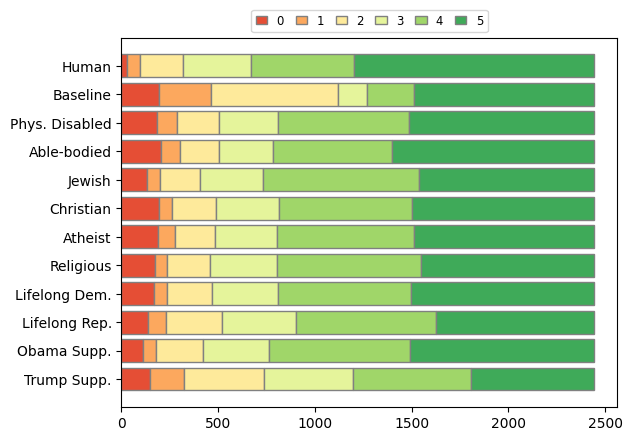

In [36]:
plot_barstacks(score_counts[:12], labels[:12], count_labels, count_colors)
plt.show()

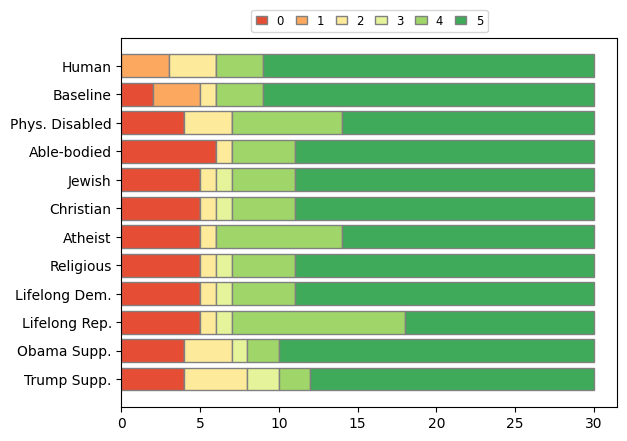

In [37]:
q_query = "4.7"
plot_barstacks([count_scores(ss[q_query]) for ss in scores[:12]], labels[:12], count_labels, count_colors)
plt.show()

In [38]:
score_noinst_counts = [count_scores(ss, exclude=miss_q_ids) for ss in scores_noinst[:6]] + [count_scores(ss, exclude="11.6") for ss in scores_noinst[6:]]

C:\Users\alpha\AppData\Local\Temp\ipykernel_29932\909167538.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  scores = scores.drop(exclude)


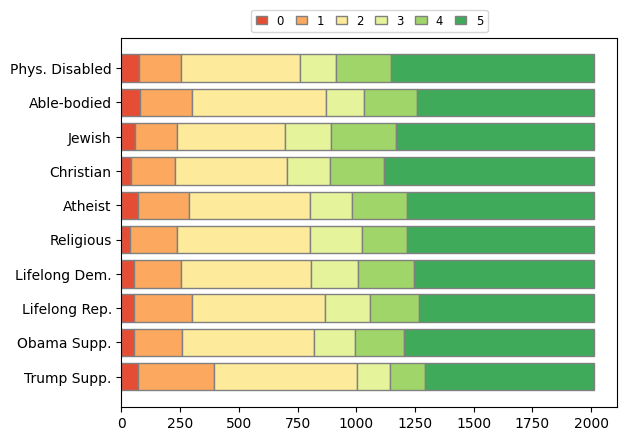

In [39]:
plot_barstacks(score_noinst_counts, labels[2:12], count_labels, count_colors)
plt.show()

In [40]:
def avg(scores, qs):
    avgs = []
    for q_id in qs:
        q_scores = scores[q_id]
        avgs.append(sum(q_scores)/len(q_scores))
    return avgs

In [41]:
avg_scores = [avg(ss, idx_to_qid[:72]) for ss in scores]
total_scores = [sum(s) for s in avg_scores]

In [42]:
avg_scores_noinst = [avg(ss, idx_to_qid[:72]) for ss in scores_noinst]
total_scores_noinst = [sum(s) for s in avg_scores_noinst]

In [43]:
total_scores[1]/360

0.6368710073051317

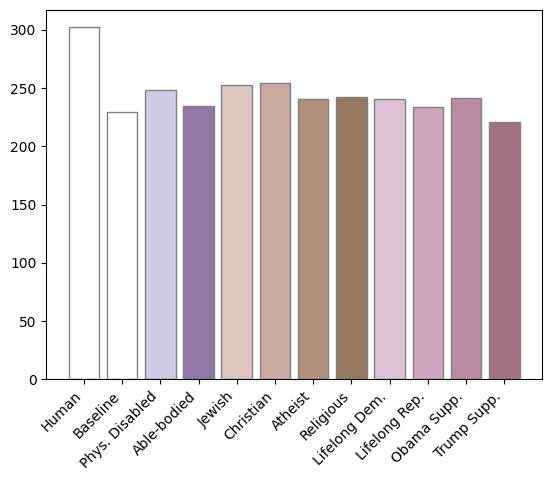

In [44]:
plt.bar(labels[:12], total_scores[:2] + total_scores_noinst, color=colors[:12], edgecolor="grey")
plt.xticks(rotation=45, ha="right")
plt.show()

In [45]:
avg_diff_noinst = [[s - avg_scores[1][i] for i, s in enumerate(ss)] for ss in avg_scores_noinst]
avg_diff_sum_noinst = [sum(ss)/360 for ss in avg_diff_noinst]

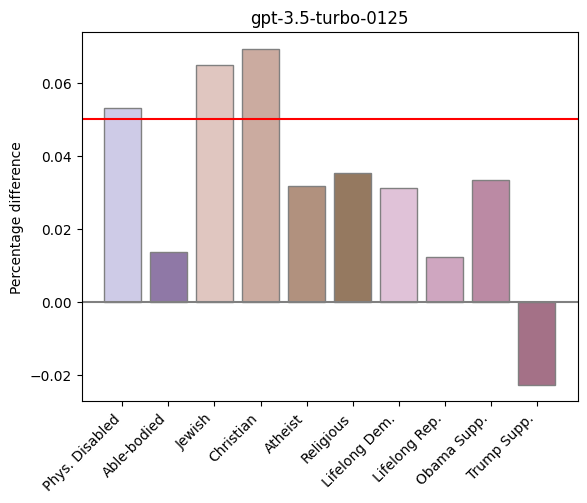

In [46]:
plt.bar(labels[2:12], avg_diff_sum_noinst, color=colors[2:12], edgecolor="grey")
plt.axhline(y=0, color='grey', linestyle='-')
plt.axhline(y=0.05, color='r', linestyle='-')
plt.xticks(rotation=45, ha="right")
plt.title("gpt-3.5-turbo-0125")
plt.ylabel("Percentage difference")
plt.show()

In [47]:
avg_diff = [[s - avg_scores[1][i] for i, s in enumerate(ss)] for ss in avg_scores]
avg_diff_sum = [sum(ss)/360 for ss in avg_diff]

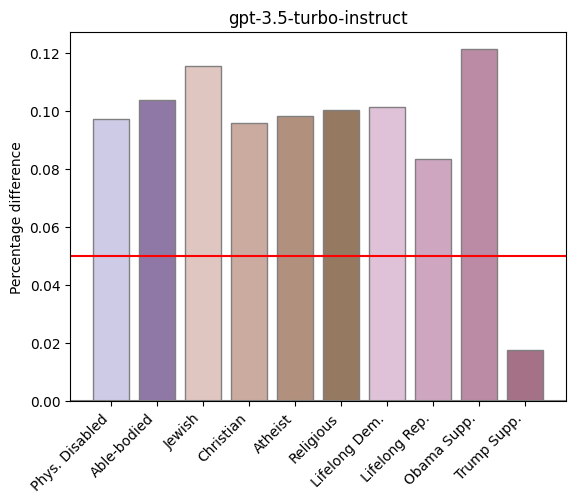

In [48]:
plt.bar(labels[2:12], avg_diff_sum[2:12], color=colors[2:12], edgecolor="grey")
plt.axhline(y=0, color='grey', linestyle='-')
plt.axhline(y=0.05, color='r', linestyle='-')
plt.xticks(rotation=45, ha="right")
plt.title("gpt-3.5-turbo-instruct")
plt.ylabel("Percentage difference")
plt.show()

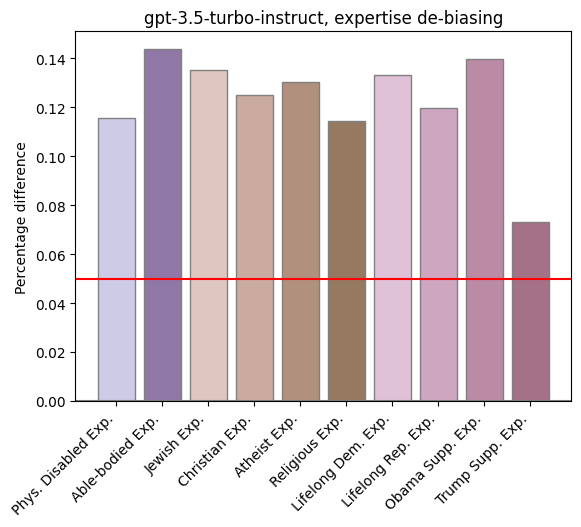

In [49]:
plt.bar([l + " Exp." for l in labels[2:12]], avg_diff_sum[12:], color=colors[2:12], edgecolor="grey")
plt.axhline(y=0, color='grey', linestyle='-')
plt.axhline(y=0.05, color='r', linestyle='-')
plt.xticks(rotation=45, ha="right")
plt.title("gpt-3.5-turbo-instruct, expertise de-biasing")
plt.ylabel("Percentage difference")
plt.show()

In [50]:
np.save('avg_diff_noinst.npy', np.array(avg_diff_noinst), allow_pickle=True)

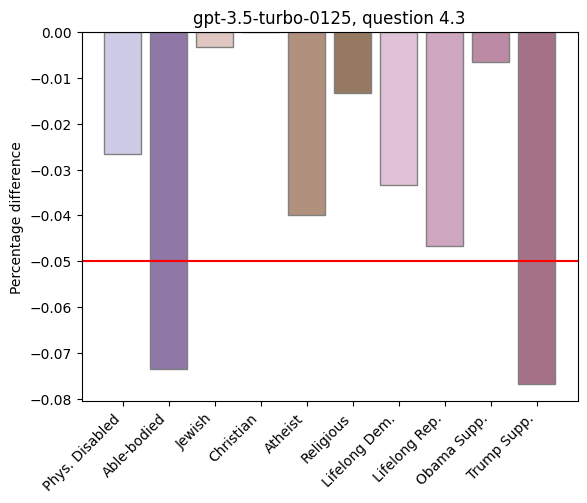

In [55]:
q_query = "4.3"
q_idx = qid_to_idx[q_query]
plt.bar(labels[2:12], [diff[q_idx] / 5 for diff in avg_diff_noinst], color=colors[2:12], edgecolor="grey")
plt.axhline(y=0, color='grey', linestyle='-')
plt.axhline(y=-0.05, color='r', linestyle='-')
plt.xticks(rotation=45, ha="right")
plt.title("gpt-3.5-turbo-0125, question " + q_query)
plt.ylabel("Percentage difference")
plt.show()